In [3]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [4]:
def to_spherical(img, K):
    h, w = img.shape[:2]
    fx, fy, cx, cy = K[0, 0], K[1, 1], K[0, 2], K[1, 2]
    
    # Generate coordinate grid
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    
    # Convert to normalized device coordinates
    x_n = (x - cx) / fx
    y_n = (y - cy) / fy
    
    # Spherical coordinates
    theta = np.arctan2(x_n, 1)
    phi = np.arctan(y_n / np.sqrt(x_n**2 + 1))
    
    # Map back to pixel coordinates
    x_s = (theta + np.pi/2) / np.pi * w
    y_s = (phi + np.pi/4) / (np.pi/2) * h
    
    # Remap image
    map_x = x_s.astype(np.float32)
    map_y = y_s.astype(np.float32)
    return cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)

def stitch_images(img1, img2):
    # Feature detection
    sift = cv2.SIFT_create()
    k1, d1 = sift.detectAndCompute(img1, None)
    k2, d2 = sift.detectAndCompute(img2, None)

    # Match features with Lowe's ratio test
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1, d2, k=2)
    good = [m[0] for m in matches if len(m) == 2 and m[0].distance < 0.75 * m[1].distance]

    # Extract matched keypoints
    src_pts = np.float32([k1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([k2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Estimate homography
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)

    # Warp and stitch
    result = cv2.warpPerspective(img2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    result[0:img1.shape[0], 0:img1.shape[1]] = img1
    return result

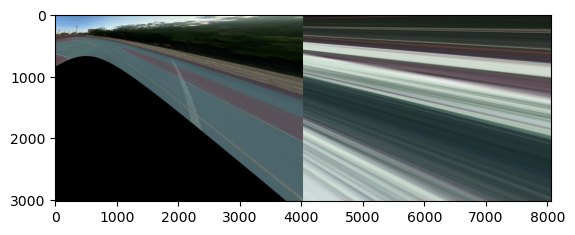

In [10]:
# Load images
img1 = plt.imread('data/left_12.jpeg')
img2 = plt.imread('data/right_12.jpeg')

# Define intrinsics (adjust to your camera)
fx = 504.02353288
fy = 426.06999938
cx = 505.68393343
cy = 240.31930792
K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

# Convert to spherical space
sph1 = to_spherical(img1, K)
sph2 = to_spherical(img2, K)

# Stitch
panorama = stitch_images(sph1, sph2)

# Show
plt.imshow(panorama);

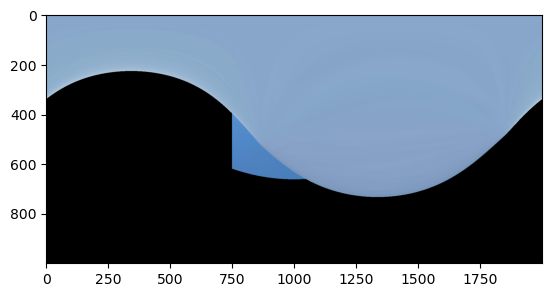

In [13]:
import cv2
import numpy as np
import math

# --- Helper Functions ---
def to_spherical(x_pano, y_pano, pano_width, pano_height):
    """Converts panorama pixel coords to spherical angles (theta, phi)."""
    theta = (x_pano / pano_width - 0.5) * 2 * np.pi
    phi = -(y_pano / pano_height - 0.5) * np.pi # Y positive down in image, phi positive up
    return theta, phi

def to_cartesian_3d(theta, phi):
    """Converts spherical angles to 3D unit vector (Z forward, Y down, X right)."""
    x = np.cos(phi) * np.sin(theta)
    y = np.sin(phi)
    z = np.cos(phi) * np.cos(theta)
    return np.array([x, y, z])

def project_to_image_plane(p_cam, K):
    """Projects 3D camera point to 2D image pixel (u,v)."""
    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    Xc, Yc, Zc = p_cam[0], p_cam[1], p_cam[2]

    if Zc <= 1e-6: # Point is behind or too close to camera plane
        return None, None

    u = fx * (Xc / Zc) + cx
    v = fy * (Yc / Zc) + cy
    return u, v

# --- Main Workflow ---
images = [plt.imread('data/left_12.jpeg'), plt.imread('data/right_12.jpeg')] # List of loaded cv2 images
# intrinsics = [...] # List of K matrices for each image

# 1. Feature Detection, Matching, Homography, Rotation Estimation
#    (Assume you get a list of rotations R_list relative to a reference image, e.g., images[0])
#    R_list[0] would be np.eye(3)
#    R_list[i] is the rotation that transforms points from image_i's frame to image_0's frame

# --- Example for SIFT/ORB and Homography to Rotation ---
# (Simplified: assumes same K for all images, pair-wise matching)
fx = 504.02353288
fy = 426.06999938
cx = 505.68393343
cy = 240.31930792
K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])

K_inv = np.linalg.inv(K)
rotations_to_ref = [np.eye(3)] * len(images) # R_i_to_ref

sift = cv2.SIFT_create()
# Assume images[0] is the reference
for i in range(1, len(images)):
    # Match features between images[i-1] and images[i]
    kp1, des1 = sift.detectAndCompute(images[i-1], None)
    kp2, des2 = sift.detectAndCompute(images[i], None)

    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    src_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)

    H_i_to_prev, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    R_i_to_prev = K_inv @ H_i_to_prev @ K
    rotations_to_ref[i] = rotations_to_ref[i-1] @ R_i_to_prev
    # (This accumulates rotations: R_i_to_ref = R_prev_to_ref @ R_i_to_prev)
# --- End Example Snippet ---


# 2. Spherical Warping
pano_width = 2000  # Desired panorama width
pano_height = 1000 # Desired panorama height
final_panorama = np.zeros((pano_height, pano_width, 3), dtype=np.uint8)
warped_images = []
warped_masks = []

for idx, img in enumerate(images):
    K_i = K
    R_i_to_ref = rotations_to_ref[idx] # Rotation from cam_i to ref_cam
    h_img, w_img = img.shape[:2]

    map_x = np.zeros((pano_height, pano_width), dtype=np.float32)
    map_y = np.zeros((pano_height, pano_width), dtype=np.float32)

    for y_pano in range(pano_height):
        for x_pano in range(pano_width):
            theta, phi = to_spherical(x_pano, y_pano, pano_width, pano_height)
            p_ref_3d = to_cartesian_3d(theta, phi) # Point in reference camera frame

            # Transform to current image i's camera frame
            # If R_i_to_ref transforms points FROM i TO ref, then R_i_to_ref.T transforms FROM ref TO i
            p_cam_i_3d = R_i_to_ref.T @ p_ref_3d

            u_src, v_src = project_to_image_plane(p_cam_i_3d, K_i)

            if u_src is not None and 0 <= u_src < w_img and 0 <= v_src < h_img:
                map_x[y_pano, x_pano] = u_src
                map_y[y_pano, x_pano] = v_src
            else:
                map_x[y_pano, x_pano] = -1 # Mark as invalid for remap
                map_y[y_pano, x_pano] = -1

    # Perform the warping
    warped_img = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    mask = np.zeros((pano_height, pano_width), dtype=np.uint8)
    mask[map_x != -1] = 255 # Create a mask for valid warped pixels

    warped_images.append(warped_img)
    warped_masks.append(mask)

# 3. Blending (Example: simple averaging or weighted blending)
# This is a very basic blending. More sophisticated methods needed for good results.
# Initialize final panorama (e.g., with first warped image)
if warped_images:
    final_panorama = warped_images[0].copy()
    current_mask = warped_masks[0].copy()

    for i in range(1, len(warped_images)):
        # Simple overwrite or basic alpha blending for overlaps
        # For alpha blending, you'd typically use feathering masks
        overlap_mask = cv2.bitwise_and(current_mask, warped_masks[i])
        
        # Simplistic: just add new image where it's valid and final_panorama is black
        final_panorama[warped_masks[i] == 255] = warped_images[i][warped_masks[i] == 255]
        # A better approach involves weighted averaging in overlap_mask regions
        current_mask = cv2.bitwise_or(current_mask, warped_masks[i])


plt.imshow(final_panorama);